In [113]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import numpy as np
import json
import requests
import time
from us import states
import scipy.stats as st
import gmaps
from scipy.stats import linregress

# gmaps API Keys
from config import (census_key, gkey)

# Configure gmaps
gmaps.configure(api_key=gkey)

In [156]:
#testing 
!pwd

/c/Users/not4e/jupyterfun


In [155]:

#load data
csv_path = "Resources/NutritionPhysicalActivityandObesity.csv"
nutrition_data = pd.read_csv(csv_path)
#nutrition_data = pd.read_csv(csv_path, index_col ="LocationDesc")

# drop unesscary columns and fix labels
nutrition_data = nutrition_data.drop(columns=['Data_Value_Unit',
                                              'Stratification1',
                                             ])
#split lat and long
nutrition_data[['Lat','Long']] = nutrition_data.GeoLocation.str.split(",",expand=True,)
#nutrition_data[['openperen']] = nutrition_data.Lat.str.split('(',expand=False,)
#nutrition_data ['Lat'] = nutrition_data['Lat'].to_numeric()
#nutrition_data.dtypes



renamecols_df = nutrition_data.rename(columns={"LocationAbbr":"StateAbbr",
                           "LocationDesc":"State",
                            "Age(years)":"Age"})

#renamecols is df before narrowing age demographic
renamecols_df.head()




#clean split columns
##cols_to_clean = ['Lat']
#nutrition_data['Lat'] = pd.to_numeric(nutrition_data['Lat'])

##cols_to_clean = re.sub("[()]", "", str( cols_to_clean))
#print(cols_to_clean)
nutrition_data.head()

#rename labels
#renamecols_df = nutrition_data.rename(columns={"LocationAbbr":"StateAbbr",
                       #    "LocationDesc":"State",
                       #     "Age(years)":"Age"})

#renamecols is df before narrowing age demographic
#renamecols_df.head()

,LocationAbbr,LocationDesc,Class,Topic,Question,Data_Value_Type,Data_Value,Data_Value_Alt,Data_Value_Footnote_Symbol,Data_Value_Footnote,Low_Confidence_Limit,High_Confidence_Limit,Sample_Size,Age,GeoLocation,Lat,Long
0,WY,Wyoming,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,Value,48.5,48.5,NaN,NaN,32.3,64.9,69.0,NaN,"(43.235541343, -108.109830353)",(43.235541343,-108.109830353)
1,DC,District of Columbia,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,Value,31.6,31.6,NaN,NaN,24.0,40.4,243.0,NaN,"(38.890371385, -77.031961127)",(38.890371385,-77.031961127)
2,AL,Alabama,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,Value,35.2,35.2,NaN,NaN,30.7,40.0,598.0,25 - 34,"(32.840571122, -86.631860762)",(32.840571122,-86.631860762)
3,US,National,Physical Activity,Physical Activity - Behavior,Percent of adults who engage in no leisure-tim...,Value,27.9,27.9,NaN,NaN,27.6,28.3,266452.0,NaN,NaN,NaN,NaN
4,US,National,Physical Activity,Physical Activity - Behavior,Percent of adults who engage in no leisure-tim...,Value,16.9,16.9,NaN,NaN,16.0,17.8,20923.0,18 - 24,NaN,NaN,NaN


In [116]:
#trim age column to include only desired age demographic
agedem_df = renamecols_df.loc[(renamecols_df["Age"] == "18 - 24")
                               |(renamecols_df["Age"] == "25 - 34")
                               |(renamecols_df["Age"] == "35 - 44")
                               |(renamecols_df["Age"] == "45 - 54"),:]
#age is df with focus age deomographic
#while working on indivudal projects we should create and save a df with the needed data
agedem_df.tail()

#define dataframe for veggie and fruit analysis
#define dataframe for excercise/behavior analysis
#define dataframe for obesity rates for gen x and gen y

,YearStart,YearEnd,StateAbbr,State,Class,Topic,Question,Data_Value,Data_Value_Alt,Low_Confidence_Limit,...,Income,Race/Ethnicity,GeoLocation,ClassID,TopicID,QuestionID,LocationID,StratificationCategory1,Lat,Long
59947,2013,2013,VA,Virginia,Physical Activity,Physical Activity - Behavior,Percent of adults who achieve at least 300 min...,34.2,34.2,28.5,...,NaN,NaN,"37.542680674, -78.457890463",PA,PA1,Q045,51,Age (years),37.542680674,-78.457890463
59950,2011,2011,AZ,Arizona,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,27.7,27.7,20.7,...,NaN,NaN,"34.86597028, -111.763811277",OWS,OWS1,Q037,4,Age (years),34.86597028,-111.763811277
59956,2014,2014,TN,Tennessee,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,39.3,39.3,35.0,...,NaN,NaN,"35.68094058, -85.774490914",OWS,OWS1,Q036,47,Age (years),35.68094058,-85.774490914
59970,2013,2013,UT,Utah,Physical Activity,Physical Activity - Behavior,Percent of adults who achieve at least 150 min...,22.6,22.6,20.5,...,NaN,NaN,"39.360700171, -111.587130635",PA,PA1,Q044,49,Age (years),39.360700171,-111.587130635
59975,2013,2013,AZ,Arizona,Physical Activity,Physical Activity - Behavior,Percent of adults who engage in no leisure-tim...,21.4,21.4,15.2,...,NaN,NaN,"34.86597028, -111.763811277",PA,PA1,Q047,4,Age (years),34.86597028,-111.763811277


In [117]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
# Create a dataframe grouping by the 'Sex' column 
age_groups = agedem_df.groupby('Age') 

# Create a dataframe counting the number of data points for each age 
age_groups_count = pd.DataFrame(age_groups['Age'].count()) 

# View the groupby dataframe 
age_groups_count

,Age
Age,
18 - 24,2142
25 - 34,2142
35 - 44,2142
45 - 54,2142


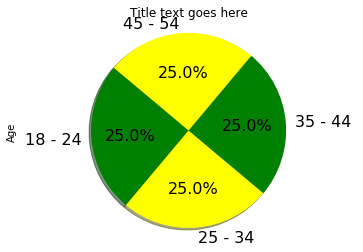

In [118]:
# Create a pie chart based off of the group series from before 
age_groups_count.plot(kind='pie', y='Age', \
                        title="Title text goes here",startangle=140,\
                        autopct='%1.1f%%',shadow=True, fontsize=16, colors =["green","yellow"],legend =False) 

# Make the axis equal to avoid plotting an egg shaped pie chart 
plt.axis("equal") 
#plt.savefig("figures/PandaPieChart.png") 
plt.show()

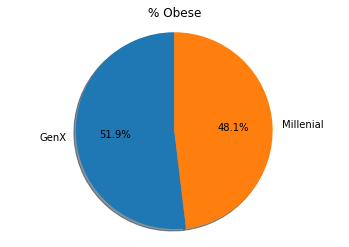

In [119]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise
labels = ['GenX', 'Millenial']
sizes = [GenX_Weight_mean, GenM_Weight_mean]


# Explode out the 'Chemical' pie piece by offsetting it a greater amount
explode = (0.1, 1.4)

fig, ax = plt.subplots()
ax.pie(sizes,
       #explode=explode,
       labels=labels,
       autopct='%1.1f%%',
       shadow=True,
       startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('% Obese')


plt.show()

In [120]:
GenX_Data = agedem_df[(agedem_df["Age"] == "35 - 44") | 
                        (agedem_df["Age"] == "45 - 54")]
GenX_Data.head()

,YearStart,YearEnd,StateAbbr,State,Class,Topic,Question,Data_Value,Data_Value_Alt,Low_Confidence_Limit,...,Income,Race/Ethnicity,GeoLocation,ClassID,TopicID,QuestionID,LocationID,StratificationCategory1,Lat,Long
26,2015,2015,NY,New York,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,29.7,29.7,26.7,...,NaN,NaN,"42.827001032, -75.543970427",OWS,OWS1,Q036,36,Age (years),42.827001032,-75.543970427
28,2013,2013,MT,Montana,Physical Activity,Physical Activity - Behavior,Percent of adults who achieve at least 300 min...,35.5,35.5,31.7,...,NaN,NaN,"47.066528972, -109.424420645",PA,PA1,Q045,30,Age (years),47.066528972,-109.424420645
46,2013,2013,SD,South Dakota,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,38.2,38.2,32.6,...,NaN,NaN,"44.353130053, -100.373530637",OWS,OWS1,Q037,46,Age (years),44.353130053,-100.373530637
54,2013,2013,WA,Washington,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,33.3,33.3,30.5,...,NaN,NaN,"47.522278629, -120.47001079",OWS,OWS1,Q036,53,Age (years),47.522278629,-120.47001079
74,2011,2011,AZ,Arizona,Physical Activity,Physical Activity - Behavior,Percent of adults who achieve at least 300 min...,34.5,34.5,29.7,...,NaN,NaN,"34.86597028, -111.763811277",PA,PA1,Q045,4,Age (years),34.86597028,-111.763811277


In [121]:
GenM_Data = agedem_df[(agedem_df["Age"] == "18 - 24") | 
                        (agedem_df["Age"] == "25 - 34")]
GenM_Data.head()

,YearStart,YearEnd,StateAbbr,State,Class,Topic,Question,Data_Value,Data_Value_Alt,Low_Confidence_Limit,...,Income,Race/Ethnicity,GeoLocation,ClassID,TopicID,QuestionID,LocationID,StratificationCategory1,Lat,Long
2,2011,2011,AL,Alabama,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,35.2,35.2,30.7,...,NaN,NaN,"32.840571122, -86.631860762",OWS,OWS1,Q036,1,Age (years),32.840571122,-86.631860762
37,2011,2011,ME,Maine,Physical Activity,Physical Activity - Behavior,Percent of adults who engage in muscle-strengt...,42.2,42.2,36.9,...,NaN,NaN,"45.254228894001, -68.985031336",PA,PA1,Q046,23,Age (years),45.254228894001,-68.985031336
39,2012,2012,AK,Alaska,Physical Activity,Physical Activity - Behavior,Percent of adults who engage in no leisure-tim...,12.8,12.8,9.8,...,NaN,NaN,"64.845079957001, -147.722059036",PA,PA1,Q047,2,Age (years),64.845079957001,-147.722059036
62,2013,2013,DC,District of Columbia,Physical Activity,Physical Activity - Behavior,Percent of adults who achieve at least 300 min...,32.3,32.3,27.0,...,NaN,NaN,"38.890371385, -77.031961127",PA,PA1,Q045,11,Age (years),38.890371385,-77.031961127
70,2014,2014,NM,New Mexico,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,33.2,33.2,28.6,...,NaN,NaN,"34.520880952, -106.240580985",OWS,OWS1,Q036,35,Age (years),34.520880952,-106.240580985


In [122]:
# Create a dataframe grouping by the 'Sex' column 
GenM_Weight_Data = GenM_Data.groupby('Question') 

# Create a dataframe counting the number of data points for each age 
GenM_Weight_Data_count = pd.DataFrame(GenM_Weight_Data['Question'].count()) 

# View the groupby dataframe 
GenM_Weight_Data_count

#GenM_Weight_Data = GenM_Data.groupby('Topic')
#GenM_Weight_Data.head()

,Question
Question,
Percent of adults aged 18 years and older who have an overweight classification,816
Percent of adults aged 18 years and older who have obesity,816
Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),408
Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week,408
Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),408
Percent of adults who engage in muscle-strengthening activities on 2 or more days a week,408
Percent of adults who engage in no leisure-time physical activity,816
Percent of adults who report consuming fruit less than one time daily,102
Percent of adults who report consuming vegetables less than one time daily,102


In [123]:
GenM_Weight_df = GenM_Data[(GenM_Data["Question"] == "Percent of adults aged 18 years and older who have obesity")]
GenM_Weight_df.count()

YearStart                  816
YearEnd                    816
StateAbbr                  816
State                      816
Class                      816
Topic                      816
Question                   816
Data_Value                 816
Data_Value_Alt             816
Low_Confidence_Limit       816
High_Confidence_Limit      816
Sample_Size                816
Total                        0
Age                        816
Education                    0
Gender                       0
Income                       0
Race/Ethnicity               0
GeoLocation                816
ClassID                    816
TopicID                    816
QuestionID                 816
LocationID                 816
StratificationCategory1    816
Lat                        816
Long                       816
dtype: int64

In [124]:
GenM_Weight_mean = GenM_Data["Data_Value"].mean()
GenM_Weight_mean

28.95961718020543

In [125]:
GenX_Weight_df = GenX_Data[(GenX_Data["Question"] == "Percent of adults aged 18 years and older who have obesity")]
GenX_Weight_df.head()

,YearStart,YearEnd,StateAbbr,State,Class,Topic,Question,Data_Value,Data_Value_Alt,Low_Confidence_Limit,...,Income,Race/Ethnicity,GeoLocation,ClassID,TopicID,QuestionID,LocationID,StratificationCategory1,Lat,Long
26,2015,2015,NY,New York,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,29.7,29.7,26.7,...,NaN,NaN,"42.827001032, -75.543970427",OWS,OWS1,Q036,36,Age (years),42.827001032,-75.543970427
54,2013,2013,WA,Washington,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,33.3,33.3,30.5,...,NaN,NaN,"47.522278629, -120.47001079",OWS,OWS1,Q036,53,Age (years),47.522278629,-120.47001079
91,2012,2012,MS,Mississippi,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,37.4,37.4,34.1,...,NaN,NaN,"32.745510099, -89.538030825",OWS,OWS1,Q036,28,Age (years),32.745510099,-89.538030825
147,2015,2015,IA,Iowa,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,37.9,37.9,33.4,...,NaN,NaN,"42.469400913, -93.816490556",OWS,OWS1,Q036,19,Age (years),42.469400913,-93.816490556
187,2011,2011,MO,Missouri,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,37.7,37.7,33.8,...,NaN,NaN,"38.635790776, -92.566300053",OWS,OWS1,Q036,29,Age (years),38.635790776,-92.566300053


In [126]:
GenX_Weight_mean = GenX_Data["Data_Value"].mean()
GenX_Weight_mean

31.26468253968251

In [144]:
GenX_activity_df = GenX_Data[(GenX_Data["Question"] == "Percent of adults who engage in no leisure-time physical activity")]
GenX_activity_df.head()

,YearStart,YearEnd,StateAbbr,State,Class,Topic,Question,Data_Value,Data_Value_Alt,Low_Confidence_Limit,...,Income,Race/Ethnicity,GeoLocation,ClassID,TopicID,QuestionID,LocationID,StratificationCategory1,Lat,Long
111,2013,2013,MD,Maryland,Physical Activity,Physical Activity - Behavior,Percent of adults who engage in no leisure-tim...,24.1,24.1,20.9,...,NaN,NaN,"39.290580964, -76.609260111",PA,PA1,Q047,24,Age (years),39.290580964,-76.609260111
152,2012,2012,MS,Mississippi,Physical Activity,Physical Activity - Behavior,Percent of adults who engage in no leisure-tim...,33.7,33.7,30.5,...,NaN,NaN,"32.745510099, -89.538030825",PA,PA1,Q047,28,Age (years),32.745510099,-89.538030825
241,2013,2013,OR,Oregon,Physical Activity,Physical Activity - Behavior,Percent of adults who engage in no leisure-tim...,19.8,19.8,16.0,...,NaN,NaN,"44.567449424, -120.155031326",PA,PA1,Q047,41,Age (years),44.567449424,-120.155031326
256,2013,2013,IA,Iowa,Physical Activity,Physical Activity - Behavior,Percent of adults who engage in no leisure-tim...,27.0,27.0,23.4,...,NaN,NaN,"42.469400913, -93.816490556",PA,PA1,Q047,19,Age (years),42.469400913,-93.816490556
287,2016,2016,CT,Connecticut,Physical Activity,Physical Activity - Behavior,Percent of adults who engage in no leisure-tim...,21.4,21.4,19.2,...,NaN,NaN,"41.56266102, -72.649840952",PA,PA1,Q047,9,Age (years),41.56266102,-72.649840952


In [128]:
GenM_activity_df = GenM_Data[(GenM_Data["Question"] == "Percent of adults who engage in no leisure-time physical activity")]
GenM_activity_df.head()

,YearStart,YearEnd,StateAbbr,State,Class,Topic,Question,Data_Value,Data_Value_Alt,Low_Confidence_Limit,...,Income,Race/Ethnicity,GeoLocation,ClassID,TopicID,QuestionID,LocationID,StratificationCategory1,Lat,Long
39,2012,2012,AK,Alaska,Physical Activity,Physical Activity - Behavior,Percent of adults who engage in no leisure-tim...,12.8,12.8,9.8,...,NaN,NaN,"64.845079957001, -147.722059036",PA,PA1,Q047,2,Age (years),64.845079957001,-147.722059036
71,2014,2014,MI,Michigan,Physical Activity,Physical Activity - Behavior,Percent of adults who engage in no leisure-tim...,16.3,16.3,13.0,...,NaN,NaN,"44.661319543001, -84.71439027",PA,PA1,Q047,26,Age (years),44.661319543001,-84.71439027
162,2013,2013,NE,Nebraska,Physical Activity,Physical Activity - Behavior,Percent of adults who engage in no leisure-tim...,21.3,21.3,18.6,...,NaN,NaN,"41.641040988001, -99.365720623",PA,PA1,Q047,31,Age (years),41.641040988001,-99.365720623
202,2012,2012,RI,Rhode Island,Physical Activity,Physical Activity - Behavior,Percent of adults who engage in no leisure-tim...,15.1,15.1,10.6,...,NaN,NaN,"41.708280193, -71.522470314",PA,PA1,Q047,44,Age (years),41.708280193,-71.522470314
291,2016,2016,GA,Georgia,Physical Activity,Physical Activity - Behavior,Percent of adults who engage in no leisure-tim...,19.8,19.8,15.2,...,NaN,NaN,"32.839681093, -83.627580346",PA,PA1,Q047,13,Age (years),32.839681093,-83.627580346


In [129]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM Questions
Question = GenX_Data.groupby('Question') 
Question.head()

Question_mean = Question["Data_Value"].mean()
Question_median = Question["Data_Value"].median()
Question_variance = Question["Data_Value"].var()
Question_std = Question["Data_Value"].std()
Question_sem = Question["Data_Value"].sem()

GenX_Q_Summary = pd.DataFrame({"Mean":Question_mean, "Median":Question_median, "Variance":Question_variance, "Standard Deviation":Question_std, "SEM":Question_sem})
GenX_Q_Summary

,Mean,Median,Variance,Standard Deviation,SEM
Question,,,,,
Percent of adults aged 18 years and older who have an overweight classification,36.369853,36.5,6.876734,2.622353,0.091801
Percent of adults aged 18 years and older who have obesity,33.784314,33.6,24.989570,4.998957,0.174998
Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),49.540931,49.6,32.624684,5.711802,0.282776
Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week,19.254412,19.3,11.701700,3.420775,0.169354
Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),29.075980,28.6,21.562468,4.643540,0.229890
Percent of adults who engage in muscle-strengthening activities on 2 or more days a week,28.081618,28.7,17.020325,4.125570,0.204246
Percent of adults who engage in no leisure-time physical activity,24.211397,23.5,28.198508,5.310227,0.185895
Percent of adults who report consuming fruit less than one time daily,37.486275,37.4,31.718226,5.631894,0.557641
Percent of adults who report consuming vegetables less than one time daily,16.894118,16.8,9.780361,3.127357,0.309654


In [130]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM Question
Question = GenM_Data.groupby('Question') 
Question.head()

Question_mean = Question["Data_Value"].mean()
Question_median = Question["Data_Value"].median()
Question_variance = Question["Data_Value"].var()
Question_std = Question["Data_Value"].std()
Question_sem = Question["Data_Value"].sem()

GenM_Q_Summary = pd.DataFrame({"Mean":Question_mean, "Median":Question_median, "Variance":Question_variance, "Standard Deviation":Question_std, "SEM":Question_sem})
GenM_Q_Summary

,Mean,Median,Variance,Standard Deviation,SEM
Question,,,,,
Percent of adults aged 18 years and older who have an overweight classification,29.597794,29.95,22.095652,4.700601,0.164554
Percent of adults aged 18 years and older who have obesity,22.248284,22.30,49.230623,7.016454,0.245625
Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),52.290931,51.95,31.087903,5.575653,0.276036
Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week,26.351961,26.10,26.368547,5.135031,0.254222
Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),30.132598,29.60,24.676109,4.967505,0.245928
Percent of adults who engage in muscle-strengthening activities on 2 or more days a week,40.322794,39.85,40.781518,6.386041,0.316156
Percent of adults who engage in no leisure-time physical activity,18.149387,17.70,19.045153,4.364075,0.152773
Percent of adults who report consuming fruit less than one time daily,38.741176,38.30,22.052545,4.696014,0.464975
Percent of adults who report consuming vegetables less than one time daily,21.205882,20.35,21.967688,4.686970,0.464079


In [131]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM Questions
# This method produces everything in a single groupby function.
age_stats = agedem_df.groupby('Age') 
age_stats.head()

age_stats_mean = age_stats["Data_Value"].mean()
age_stats_median = age_stats["Data_Value"].median()
age_stats_variance = age_stats["Data_Value"].var()
age_stats_std = age_stats["Data_Value"].std()
age_stats_sem = age_stats["Data_Value"].sem()

S_Summary = pd.DataFrame({"Mean":age_stats_mean, "Median":age_stats_median, "Variance":age_stats_variance, "Standard Deviation":age_stats_std, "SEM":age_stats_sem})
S_Summary

,Mean,Median,Variance,Standard Deviation,SEM
Age,,,,,
18 - 24,28.169421,25.80,168.287346,12.972561,0.280295
25 - 34,29.749813,29.30,89.488863,9.459855,0.204397
35 - 44,30.815126,30.50,85.874465,9.266848,0.200227
45 - 54,31.714239,31.85,91.285397,9.554339,0.206439


In [132]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM Questions
# This method produces everything in a single groupby function.

Question = agedem_df.groupby('Question') 
Question.head()

Question_mean = Question["Data_Value"].mean()
Question_median = Question["Data_Value"].median()
Question_variance = Question["Data_Value"].var()
Question_std = Question["Data_Value"].std()
Question_sem = Question["Data_Value"].sem()

Q_Summary = pd.DataFrame({"Mean":Question_mean, "Median":Question_median, "Variance":Question_variance, "Standard Deviation":Question_std, "SEM":Question_sem})
Q_Summary

,Mean,Median,Variance,Standard Deviation,SEM
Question,,,,,
Percent of adults aged 18 years and older who have an overweight classification,32.983824,34.20,25.949536,5.094069,0.126097
Percent of adults aged 18 years and older who have obesity,28.016299,29.25,70.377735,8.389144,0.207662
Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),50.915931,50.70,33.710151,5.806044,0.203252
Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week,22.803186,21.95,31.621021,5.623257,0.196853
Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),29.604289,29.10,23.370374,4.834291,0.169234
Percent of adults who engage in muscle-strengthening activities on 2 or more days a week,34.202206,32.60,66.373026,8.146964,0.285201
Percent of adults who engage in no leisure-time physical activity,21.180392,20.65,32.799971,5.727126,0.141767
Percent of adults who report consuming fruit less than one time daily,38.113725,37.55,27.148579,5.210430,0.364803
Percent of adults who report consuming vegetables less than one time daily,19.050000,18.30,20.466552,4.523997,0.316743


In [133]:
# Create a dataframe grouping by the 'State' column 
state_groups = agedem_df.groupby('State') 

# Create a dataframe counting the number of data points for each age 
state_groups_count = pd.DataFrame(state_groups['State'].count()) 

# View the groupby dataframe 
state_groups_count.head()

,State
State,
Alabama,168
Alaska,168
Arizona,168
Arkansas,168
California,168


In [134]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM Questions
# This method produces everything in a single groupby function.
state_stats = GenX_Data.groupby('State') 
state_stats.head()

state_stats_mean = state_stats["Data_Value"].mean()
state_stats_median = state_stats["Data_Value"].median()
state_stats_variance = state_stats["Data_Value"].var()
state_stats_std = state_stats["Data_Value"].std()
state_stats_sem = state_stats["Data_Value"].sem()

St_Summary = pd.DataFrame({"Mean":state_stats_mean, "Median":state_stats_median, "Variance":state_stats_variance, "Standard Deviation":state_stats_std, "SEM":state_stats_sem})
St_Summary.head()

,Mean,Median,Variance,Standard Deviation,SEM
State,,,,,
Alabama,31.432143,32.80,79.146063,8.896407,0.970678
Alaska,32.664286,32.90,112.293649,10.596870,1.156213
Arizona,31.594048,31.15,84.304181,9.181731,1.001809
Arkansas,31.838095,33.55,94.293471,9.710483,1.059501
California,31.236905,29.40,104.422838,10.218749,1.114957


The correlation between both factors is 0.0


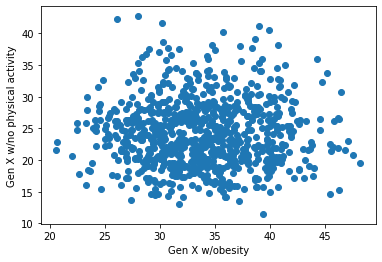

In [135]:
# The next example will compute the Pearson correlation coefficient between "Income per Capita" and "Average Alcohol Consumed"
GenX_Weight = GenX_Weight_df.iloc[:,7]
GenX_Activity = GenX_activity_df.iloc[:,7]
correlation = st.pearsonr(GenX_Weight,GenX_Activity)

# Compare the calcualted Pearson's r to the plots
plt.scatter(GenX_Weight,GenX_Activity)
plt.xlabel('Gen X w/obesity')
plt.ylabel('Gen X w/no physical activity')
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.show()

The correlation between both factors is 0.04


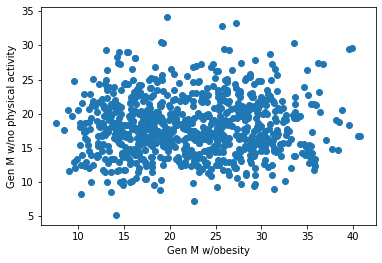

In [136]:
# The next example will compute the Pearson correlation coefficient between "Income per Capita" and "Average Alcohol Consumed"
GenM_Weight = GenM_Weight_df.iloc[:,7]
GenM_Activity = GenM_activity_df.iloc[:,7]
correlation = st.pearsonr(GenM_Weight,GenM_Activity)

# Compare the calcualted Pearson's r to the plots
plt.scatter(GenM_Weight,GenM_Activity)
plt.xlabel('Gen M w/obesity')
plt.ylabel('Gen M w/no physical activity')
print(f"The correlation between both factors is {round(correlation[0],2)}")
plt.show()

In [137]:
# Merge the datasets using the state columns
#census_data = pd.merge(GenM_Weight_df, GenX_Weight_df, how="left", left_on="Name", right_on="State")

# Save the updated dataframe as a csv
##census_data.to_csv("Resources/state_census_data.csv", encoding="utf-8", index=False)
##census_data.tail()

# Convert poverty rate as a list
# Convert unemployment rate to list
#GenM_Obesity_rate = GenM_Weight_df["Data_Value"].tolist()
#GenX_obesity_rate = GenX_Weight_df["Data_Value"].tolist()


# Create a map using state centroid coordinates to set markers
#marker_locations = nutrition_data[['Lat', 'Long']]

# Create a marker_layer using the poverty list and the unemployment rate to fill the info box
#fig = gmaps.figure()
#markers = gmaps.marker_layer(marker_locations,
    #info_box_content=[f"Gen X Obesity Rate: {rate}" for rate in GenX_obesity_rate])
#fig.add_layer(markers)
#fig

The r-squared is: 0.0013907261339774725


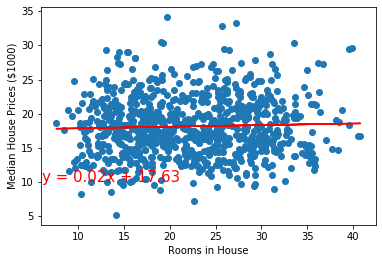

In [138]:
 # Print out the r-squared value along with the plot.
x_values = GenM_Weight
y_values = GenM_Activity
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Rooms in House')
plt.ylabel('Median House Prices ($1000)')
print(f"The r-squared is: {rvalue**2}")
plt.show()

In [139]:
# Store 'Lat' and 'Lng' into  locations 
locations = GenX_Weight_df[["Lat", "Long"]].astype(float)
locations

# Convert Obesity Rate to float and store
obesity_rate = GenX_Weight_df["Data_Value"].astype(float)

In [142]:
GenX_Weight_df.head()

,YearStart,YearEnd,StateAbbr,State,Class,Topic,Question,Data_Value,Data_Value_Alt,Low_Confidence_Limit,...,Income,Race/Ethnicity,GeoLocation,ClassID,TopicID,QuestionID,LocationID,StratificationCategory1,Lat,Long
26,2015,2015,NY,New York,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,29.7,29.7,26.7,...,NaN,NaN,"42.827001032, -75.543970427",OWS,OWS1,Q036,36,Age (years),42.827001032,-75.543970427
54,2013,2013,WA,Washington,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,33.3,33.3,30.5,...,NaN,NaN,"47.522278629, -120.47001079",OWS,OWS1,Q036,53,Age (years),47.522278629,-120.47001079
91,2012,2012,MS,Mississippi,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,37.4,37.4,34.1,...,NaN,NaN,"32.745510099, -89.538030825",OWS,OWS1,Q036,28,Age (years),32.745510099,-89.538030825
147,2015,2015,IA,Iowa,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,37.9,37.9,33.4,...,NaN,NaN,"42.469400913, -93.816490556",OWS,OWS1,Q036,19,Age (years),42.469400913,-93.816490556
187,2011,2011,MO,Missouri,Obesity / Weight Status,Obesity / Weight Status,Percent of adults aged 18 years and older who ...,37.7,37.7,33.8,...,NaN,NaN,"38.635790776, -92.566300053",OWS,OWS1,Q036,29,Age (years),38.635790776,-92.566300053


In [143]:
# Create a poverty Heatmap layer
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=obesity_rate, 
                                 dissipating=False, max_intensity=100,
                                 point_radius = 1)

fig.add_layer(heat_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [ ]:
Figure(layout=FigureLayout(height='420px'))

In [148]:
# Convert bank rate to list
activity_rate = GenX_activity_df["Data_Value"].tolist()

In [150]:
# Create bank symbol layer
activity_layer = gmaps.symbol_layer(
    locations, fill_color='rgba(0, 150, 0, 0.4)',
    stroke_color='rgba(0, 0, 150, 0.4)', scale=2,
    info_box_content=[f"Percent of population with no activity: {activity}" for activity in activity_rate]
)


fig = gmaps.figure()
fig.add_layer(activity_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [ ]:
Figure(layout=FigureLayout(height='420px'))

In [153]:
# Create a combined map
fig = gmaps.figure()

fig.add_layer(heat_layer)
fig.add_layer(activity_layer)

fig

Figure(layout=FigureLayout(height='420px'))

In [154]:
 Figure(layout=FigureLayout(height='420px'))

NameError: name 'Figure' is not defined